In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [155]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleansing

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [157]:
#As bmi contains null values
df.bmi = df.bmi.fillna(-99)

In [158]:
# define target variable
target = df.stroke


# calc frequencies
target_count = target.value_counts()
print(target_count)
print('Percentage of strokes [1]:', np.round(100*target_count[1] / target_count.sum(),2), '%')

0    4861
1     249
Name: stroke, dtype: int64
Percentage of strokes [1]: 4.87 %


In [159]:
df1 = df 
ever_married_mapping = {'No': 0, 'Yes': 1}
df1['ever_married'] = df['ever_married'].map(ever_married_mapping)
Residence_type_mapping = {'Rural': 0, 'Urban': 1}
df1['Residence_type'] = df['Residence_type'].map(Residence_type_mapping)

datasetDummies_gender = pd.get_dummies(df['gender'], prefix = 'gender_encoded')
datasetDummies_work_type = pd.get_dummies(df['work_type'], prefix = 'work_type_encoded') 
datasetDummies_smoking_status = pd.get_dummies(df['smoking_status'], prefix = 'smoking_status_encoded')

target1 = pd.get_dummies(target, prefix = 'target')

df1.drop("gender", axis=1, inplace=True)
df1.drop("work_type", axis=1, inplace=True)
df1.drop("smoking_status", axis=1, inplace=True)
df1.drop("stroke", axis=1, inplace=True)

In [160]:
df1 = pd.concat([df1, datasetDummies_gender], axis=1)
df1 = pd.concat([df1, datasetDummies_work_type], axis=1)
df1 = pd.concat([df1, datasetDummies_smoking_status], axis=1)
df1.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_encoded_Female,gender_encoded_Male,gender_encoded_Other,work_type_encoded_Govt_job,work_type_encoded_Never_worked,work_type_encoded_Private,work_type_encoded_Self-employed,work_type_encoded_children,smoking_status_encoded_Unknown,smoking_status_encoded_formerly smoked,smoking_status_encoded_never smoked,smoking_status_encoded_smokes
0,9046,67.0,0,1,1,1,228.69,36.6,0,1,0,0,0,1,0,0,0,1,0,0
1,51676,61.0,0,0,1,0,202.21,-99.0,1,0,0,0,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,1,0,105.92,32.5,0,1,0,0,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,1,1,171.23,34.4,1,0,0,0,0,1,0,0,0,0,0,1
4,1665,79.0,1,0,1,0,174.12,24.0,1,0,0,0,0,0,1,0,0,0,1,0


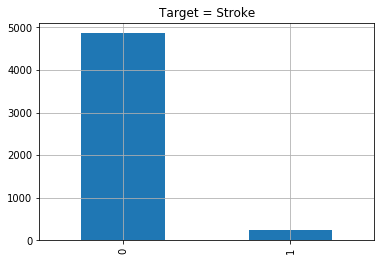

In [216]:
target_count.plot(kind='bar')
plt.title('Target = Stroke')
plt.grid()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,1:], target1, test_size=0.30, random_state=42)

## Feature Engineering

C:\Users\Daim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Old Shape: (3577, 19) New shape: (3577, 3)




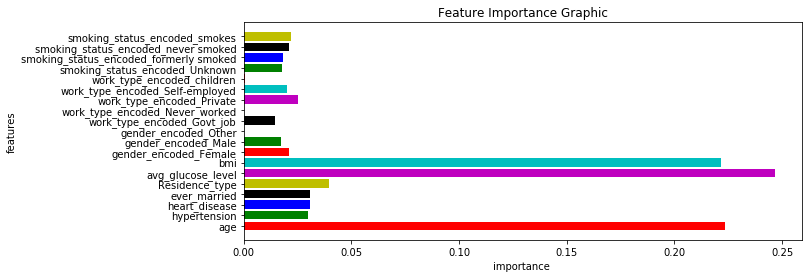

In [217]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
  
best_features = SelectFromModel(model)
best_features.fit(X_train, y_train)
features = df1.columns[1:]
transformedX = best_features.transform(X_train)
print(f"Old Shape: {X_train.shape} New shape: {transformedX.shape}")
print("\n")
imp_feature = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
plt.figure(figsize=(10,4))
plt.title("Feature Importance Graphic")
plt.xlabel("importance ")
plt.ylabel("features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'rgbkymc')
plt.show()
X_train = X_train[['bmi', 'avg_glucose_level', 'age']]

Will use only the three most impotant features namely bmi, avg_glucose_level and age

## Model building

In [219]:
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
3577/3577 [==============================] - 5s 1ms/step - loss: 2.5448 - accuracy: 0.6925
Epoch 2/10
3577/3577 [==============================] - 1s 241us/step - loss: 0.2199 - accuracy: 0.95420s - loss: 0.2
Epoch 3/10
3577/3577 [==============================] - 1s 332us/step - loss: 0.2115 - accuracy: 0.9544
Epoch 4/10
3577/3577 [==============================] - 1s 296us/step - loss: 0.2032 - accuracy: 0.9553
Epoch 5/10
3577/3577 [==============================] - 1s 378us/step - loss: 0.1898 - accuracy: 0.95470s - loss: 0.1875 - accu - ETA: 0s - loss: 0.1792 - accuracy:  - ETA: 0s - loss: 0.1859 - accu
Epoch 6/10
3577/3577 [==============================] - 1s 281us/step - loss: 0.1761 - accuracy: 0.9555
Epoch 7/10
3577/3577 [==============================] - 1s 300us/step - loss: 0.1714 - accuracy: 0.9555
Epoch 8/10
3577/3577 [==============================] - 1s 329us/step - loss: 0.1690 - accuracy: 0.9555
Epoch 9/10
3577/3577 [==============================] - 1s 268

In [221]:
prediction = model.predict(X_test[['bmi', 'avg_glucose_level', 'age']])
print(prediction[0], '\n',y_test.iloc[0])

[0.9679633  0.03203674] 
 target_0    1
target_1    0
Name: 4688, dtype: uint8


The predicted array have 2 values for each observation which is actually the probability of whether the stroke happens or not.  

In [244]:
from itertools import combinations
def powerset(string):
    lis = []
    count = 0
    for i in range(1,len(string)+1):
        for element in combinations(string,i):
            lis.append(element)
    return lis

In [249]:
def directkb(data):
    counts=dict()
    kb = []
    rang = len(data)
    for i in range(0,rang):
        feaVal = data.iloc[i]
        
        print(feaVal[0])
        label= target[i]
        s = powerset(feaVal)
        print(s)
    

In [250]:
directkb(X_train.iloc[:1,:])

16.2
[(16.2,), (90.42,), (4.0,), (16.2, 90.42), (16.2, 4.0), (90.42, 4.0), (16.2, 90.42, 4.0)]
